In [68]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

In [69]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2), # input = 3 meaning R, G and B
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(128 * 14 * 14, 2) # 14 here because 224 (input dimension of image) / 2 * 4 (pooling size * number of layers), there is 2 output (0 for not_stop and 1 for stop)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [70]:
# Function to load images and labels
def load_images(folder_path):
    images = []
    labels = []
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor()])

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert("RGB")
        img = transform(img)
        images.append(img)
        labels.append(0 if 'not_stop' in img_path else 1)

    return torch.stack(images), torch.tensor(labels, dtype=torch.long)

In [71]:
# Load images and labels for stop and not_stop separately
stop_images, stop_labels = load_images('C:/Users/visha/Documents/Python_files/data/stop')
not_stop_images, not_stop_labels = load_images('C:/Users/visha/Documents/Python_files/data/not_stop')

# Combine stop and not_stop images
all_images = torch.cat((stop_images, not_stop_images), dim=0)
all_labels = torch.cat((stop_labels, not_stop_labels), dim=0)

# Shuffle the combined dataset
shuffle_indices = torch.randperm(len(all_images))
all_images = all_images[shuffle_indices]
all_labels = all_labels[shuffle_indices]

# Split the data into train and test sets (80-20 split)
split_ratio = 0.8
split_idx = int(len(all_images) * split_ratio)

train_images, test_images = all_images[:split_idx], all_images[split_idx:]
train_labels, test_labels = all_labels[:split_idx], all_labels[split_idx:]

# Create PyTorch datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [83]:
# Instantiate the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # is it better to use bce loss for binary classification?
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 45  # You can adjust this based on your dataset size and convergence
for epoch in range(num_epochs):
    for images_batch, labels_batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

Epoch [1/45], Loss: 0.7140
Epoch [2/45], Loss: 0.6905
Epoch [3/45], Loss: 0.6358
Epoch [4/45], Loss: 0.4309
Epoch [5/45], Loss: 0.3055
Epoch [6/45], Loss: 0.4623
Epoch [7/45], Loss: 0.4990
Epoch [8/45], Loss: 0.2618
Epoch [9/45], Loss: 0.4664
Epoch [10/45], Loss: 0.1521
Epoch [11/45], Loss: 0.2178
Epoch [12/45], Loss: 0.1728
Epoch [13/45], Loss: 0.1785
Epoch [14/45], Loss: 0.1862
Epoch [15/45], Loss: 0.1623
Epoch [16/45], Loss: 0.1253
Epoch [17/45], Loss: 0.1451
Epoch [18/45], Loss: 0.0827
Epoch [19/45], Loss: 0.0956
Epoch [20/45], Loss: 0.0471
Epoch [21/45], Loss: 0.1050
Epoch [22/45], Loss: 0.0133
Epoch [23/45], Loss: 0.0077
Epoch [24/45], Loss: 0.0038
Epoch [25/45], Loss: 0.0223
Epoch [26/45], Loss: 0.0689
Epoch [27/45], Loss: 0.0222
Epoch [28/45], Loss: 0.0803
Epoch [29/45], Loss: 0.0250
Epoch [30/45], Loss: 0.0024
Epoch [31/45], Loss: 0.0863
Epoch [32/45], Loss: 0.0098
Epoch [33/45], Loss: 0.0020
Epoch [34/45], Loss: 0.0018
Epoch [35/45], Loss: 0.0015
Epoch [36/45], Loss: 0.0016
E

In [84]:
# Function to predict and classify an image

# Define a transform to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


def classify_image(image_path):
    # Read the image using PIL
    img = Image.open(image_path).convert("RGB")

    # Apply the defined transform
    img_tensor = preprocess(img)

    # Add an extra dimension to represent the batch (single image in this case)
    img_tensor = img_tensor.unsqueeze(0)

    # Disable gradient calculation during inference
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()
        
        # Perform forward pass to get the output predictions
        output = model(img_tensor)
        
        # Get the predicted class index
        _, predicted = torch.max(output, 1) 
        
        # Return the predicted class index as an integer
        return predicted.item()

In [75]:
# Define the base directory for images
base_image_dir = 'C:/Users/visha/Documents/Python_files/data/'

# Test the classifier on an additional image
test_image_prediction = classify_image(os.path.join(base_image_dir, 'stop_image.jpeg'))

print("Test Image Prediction:", test_image_prediction)

Test Image Prediction: 1


In [85]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images_batch, labels_batch in test_dataloader:
        outputs = model(images_batch)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

accuracy = correct / total * 100
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 80.00%


Test Image Prediction: stop


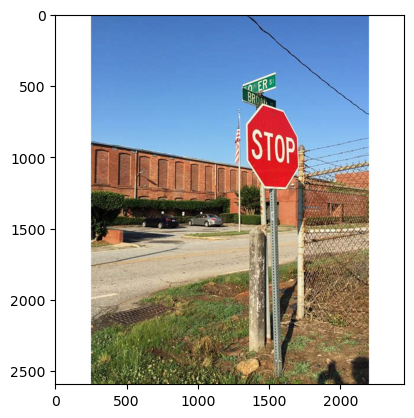

In [86]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Define the base directory for images
base_image_dir = 'C:/Users/visha/Documents/Python_files/data/'

# Test the classifier on an additional image
test_image_prediction = classify_image(os.path.join(base_image_dir, 'stop_image.jpeg'))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir, 'stop_image.jpeg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: not_stop


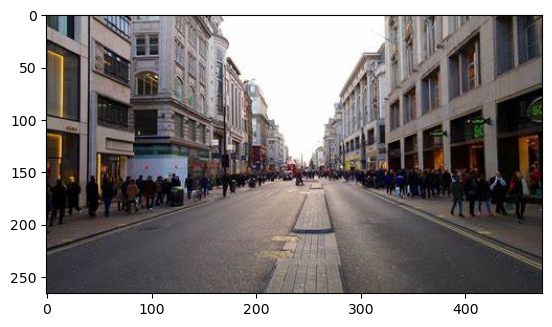

In [88]:
# Test the classifier on an additional image
test_image_prediction = classify_image(os.path.join(base_image_dir,'OIP.jpeg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'OIP.jpeg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: stop


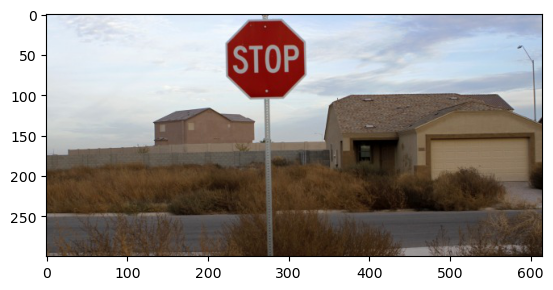

In [90]:
# Test the classifier on stop image folder
test_image_prediction = classify_image(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/stop/1.jpg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/stop/1.jpg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: stop


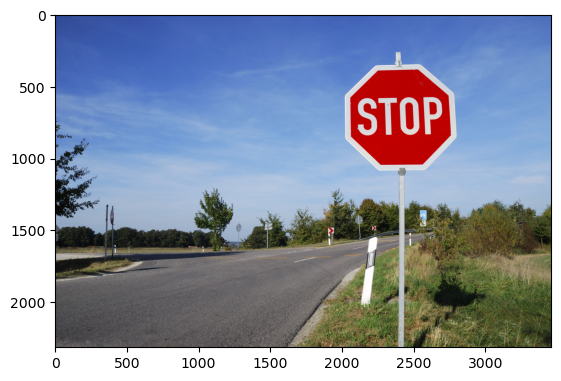

In [91]:
# Test the classifier on stop image folder
test_image_prediction = classify_image(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/stop/2.jpg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/stop/2.jpg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: stop


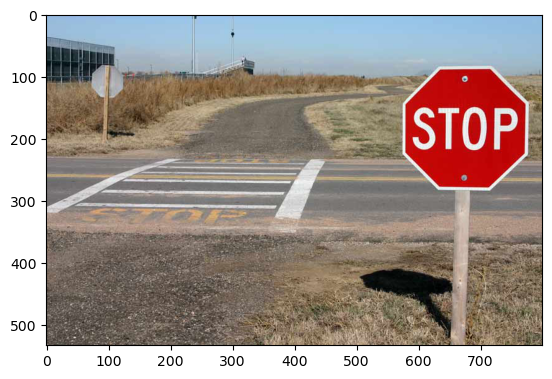

In [92]:
# Test the classifier on stop image folder
test_image_prediction = classify_image(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/stop/3.jpg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/stop/3.jpg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: stop


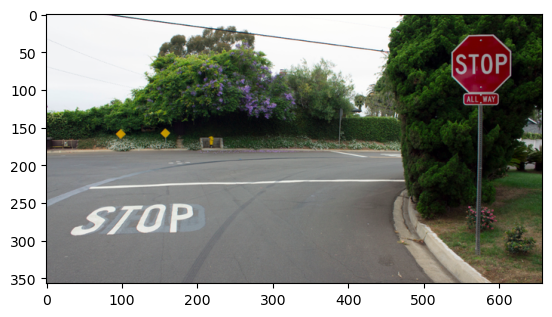

In [94]:
# Test the classifier on stop image folder
test_image_prediction = classify_image(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/stop/4.png' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/stop/4.png'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: not_stop


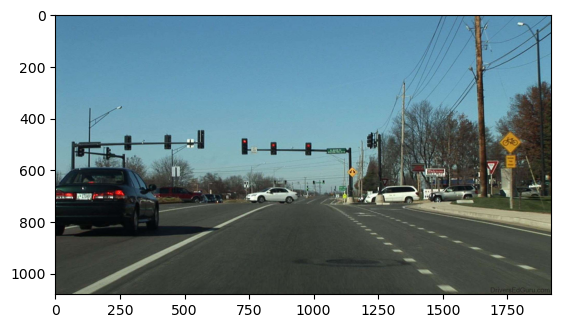

In [95]:
# Test the classifier on non-stop image folder
test_image_prediction = classify_image(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/not_stop/101.jpg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/not_stop/101.jpg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: not_stop


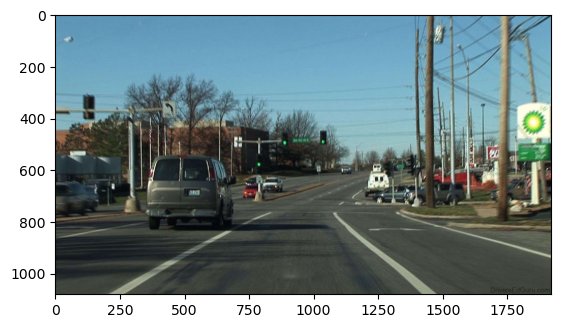

In [96]:
# Test the classifier on non-stop image folder
test_image_prediction = classify_image(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/not_stop/102.jpg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/not_stop/102.jpg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: not_stop


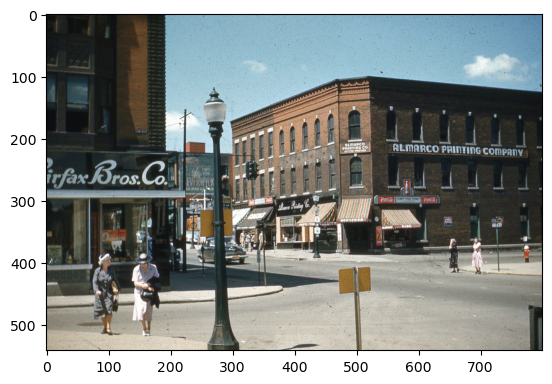

In [97]:
# Test the classifier on non-stop image folder
test_image_prediction = classify_image(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/not_stop/200.jpg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'C:/Users/visha/Documents/Python_files/data/not_stop/200.jpg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: stop


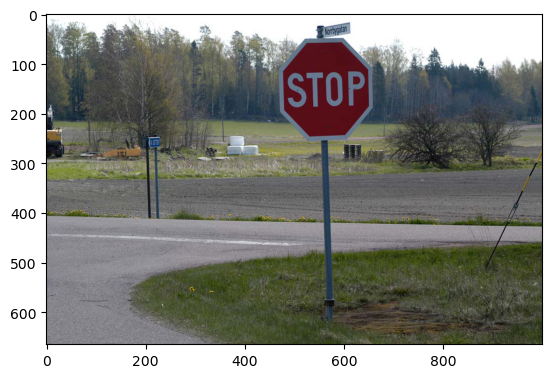

In [98]:
# Test the classifier on random image from google
test_image_prediction = classify_image(os.path.join(base_image_dir,'stopping.jpeg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'stopping.jpeg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()

Test Image Prediction: stop


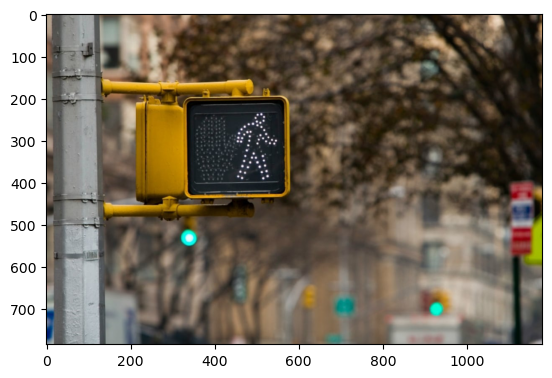

In [99]:
# Test the classifier on random image from google
test_image_prediction = classify_image(os.path.join(base_image_dir,'non_stopping.jpeg' ))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir,'non_stopping.jpeg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()